In [11]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(progress_bar=True, nb_workers=multiprocessing.cpu_count())

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
def break_and_compare(ls, k):
    n = len(ls)
    while n % k != 0:
        n -= 1
    to_break = ls[:n]
    residual = ls[n:]
    chunk_size = n // k
    while len(residual) < chunk_size:
        # split into chunks
        chunks = [to_break[i:i + chunk_size] for i in range(0, len(to_break), chunk_size)]
        chunksMatch = True
        # compare all chunks to first chunk
        for chunk in chunks[1:]:
            if chunk != chunks[0]:
                chunksMatch = False
                break
        if chunksMatch:
            # compare residual to first chunk
            if residual == chunks[0][:len(residual)]:
                return chunks[0]
        chunk_size -= 1
        new_residual = to_break[chunk_size * k:]
        to_break = to_break[:chunk_size * k]
        residual = new_residual + residual
    return []

In [13]:
def break_and_compare_wrapper(ls, start_k, end_k):
    # end_k is inclusive
    ls = list(ls)
    for k in range(start_k, end_k + 1):
        result = break_and_compare(ls, k)
        if result:
            return result, k
    return [], -1

In [14]:
break_and_compare([1,2,3,4,1,2,3,4,1,2,3,4,1], k=3)

[1, 2, 3, 4]

In [15]:
break_and_compare_wrapper([1,2,3,4,1,2,3,4,1,2,3,4,1], start_k=2, end_k=4)

([1, 2, 3, 4], 3)

In [46]:
files = os.listdir('../data')
# choose files without 'lrs' or 'mrs' in the name
files = [file for file in files if 'lrs' not in file and 'mrs' not in file and 'chunk' not in file]
files

['pythia-70m.pkl',
 'pythia-160m.pkl',
 'pythia-410m.pkl',
 'pythia-1b.pkl',
 'pythia-1.4b.pkl',
 'pythia-2.8b.pkl',
 'pythia-6.9b.pkl',
 'pythia-70m-deduped.pkl',
 'pythia-160m-deduped.pkl',
 'pythia-410m-deduped.pkl',
 'pythia-1b-deduped.pkl',
 'pythia-1.4b-deduped.pkl',
 'pythia-2.8b-deduped.pkl',
 'pythia-6.9b-deduped.pkl']

In [17]:
def get_df_with_chunk_and_k(file):
    df = pickle.load(open('../data/' + file, 'rb'))
    df['chunk'], df['k'] = zip(*df['tokens'].parallel_apply(break_and_compare_wrapper, args=(2, 10)))
    # save df as pickle
    pickle.dump(df, open('../data/' + file + "_with_chunk_and_k", 'wb'))
    return df
    

In [18]:
def load_df_with_chunk_and_k(file):
    return pickle.load(open('../data/' + file + "_with_chunk_and_k", 'rb'))

In [24]:
df = load_df_with_chunk_and_k(files[0])

In [33]:
def plot_chunk_length(file):
    df = load_df_with_chunk_and_k(file)
    df_without_k_negative_1 = df[df['k'] != -1]
    # bar plot of df_without_k_negative_1['k'] and save
    plt.figure(figsize=(10, 5))
    sns.countplot(x='k', data=df_without_k_negative_1)
    plt.title('Distribution of k for ' + file)
    plt.savefig('../plots/' + file + '_chunk_length.png')
    # plt.show()

In [42]:
df['k'].value_counts().to_dict()

{-1: 434409, 2: 26352, 3: 3192}

In [44]:
r23 = df['k'].value_counts().to_dict()[2]/ df['k'].value_counts().to_dict()[3]
r23

8.25563909774436

In [34]:
# for file in files:
#     print(file)
#     get_df_with_chunk_and_k(file)

In [ ]:
for file in files:
    print(file)
    plot_chunk_length(file)

In [48]:
df_ratios = pd.DataFrame(columns=['file', 'ratio_2_3', 'ratio_2_total', 'ratio_3_total', 'ratio_not_memorized_total'])
for file in files:
    df = load_df_with_chunk_and_k(file)
    k_dist = df['k'].value_counts().to_dict()
    ratio_2_3 = k_dist[2]/k_dist[3]
    ratio_2_total = k_dist[2]/sum(k_dist.values())
    ratio_3_total = k_dist[3]/sum(k_dist.values())
    ratio_minusone_total = k_dist[-1]/sum(k_dist.values())
    print(file, ratio_2_3, ratio_2_total, ratio_3_total, ratio_minusone_total)
    df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)
df_ratios

pythia-70m.pkl 8.25563909774436 0.0567988567807515 0.006880007242112887 0.9363211359771356


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-160m.pkl 7.6353103448275865 0.04013206258618215 0.005256114129449754 0.9546118232843681


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-410m.pkl 7.111387369467926 0.02947623567385074 0.004144934615769096 0.9663788297103801


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-1b.pkl 7.14402500601106 0.023653395598105628 0.003310934043232408 0.973035670358662


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-1.4b.pkl 7.056398104265403 0.02167687494267399 0.0030719461433972813 0.9752511789139288


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-2.8b.pkl 6.949257142857143 0.01815021040823795 0.0026118202327415395 0.9792379693590205


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-6.9b.pkl 6.947783029484582 0.014554196690286373 0.002094797236546126 0.9833510060731675


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-70m-deduped.pkl 8.82479700187383 0.06867696525441855 0.007782271392739787 0.9235407633528416


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-160m-deduped.pkl 7.977067977067977 0.050275725014840116 0.006302531852476363 0.9434217431326836


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-410m-deduped.pkl 7.399150743099788 0.03867261623670378 0.005226629052363697 0.9561007547109325


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-1b-deduped.pkl 7.42813527477689 0.030622588624844484 0.004122513590837137 0.9652548977843184


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-1.4b-deduped.pkl 7.1807909604519775 0.030316850444185986 0.004221937473344547 0.9654612120824695


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-2.8b-deduped.pkl 7.0262316058861165 0.024310605507186705 0.003459977818952178 0.9722294166738611


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


pythia-6.9b-deduped.pkl 6.973104616687844 0.01959597546619818 0.0028102224967773495 0.9775938020370245


/tmp/ipykernel_1867794/597668238.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total}, ignore_index=True)


,file,ratio_2_3,ratio_2_total,ratio_3_total,ratio_not_memorized_total
0,pythia-70m.pkl,8.255639,0.056799,0.006880,0.936321
1,pythia-160m.pkl,7.635310,0.040132,0.005256,0.954612
2,pythia-410m.pkl,7.111387,0.029476,0.004145,0.966379
3,pythia-1b.pkl,7.144025,0.023653,0.003311,0.973036
4,pythia-1.4b.pkl,7.056398,0.021677,0.003072,0.975251
5,pythia-2.8b.pkl,6.949257,0.018150,0.002612,0.979238
6,pythia-6.9b.pkl,6.947783,0.014554,0.002095,0.983351
7,pythia-70m-deduped.pkl,8.824797,0.068677,0.007782,0.923541
8,pythia-160m-deduped.pkl,7.977068,0.050276,0.006303,0.943422
9,pythia-410m-deduped.pkl,7.399151,0.038673,0.005227,0.956101


In [49]:
df_ratios

,file,ratio_2_3,ratio_2_total,ratio_3_total,ratio_not_memorized_total
0,pythia-70m.pkl,8.255639,0.056799,0.006880,0.936321
1,pythia-160m.pkl,7.635310,0.040132,0.005256,0.954612
2,pythia-410m.pkl,7.111387,0.029476,0.004145,0.966379
3,pythia-1b.pkl,7.144025,0.023653,0.003311,0.973036
4,pythia-1.4b.pkl,7.056398,0.021677,0.003072,0.975251
5,pythia-2.8b.pkl,6.949257,0.018150,0.002612,0.979238
6,pythia-6.9b.pkl,6.947783,0.014554,0.002095,0.983351
7,pythia-70m-deduped.pkl,8.824797,0.068677,0.007782,0.923541
8,pythia-160m-deduped.pkl,7.977068,0.050276,0.006303,0.943422
9,pythia-410m-deduped.pkl,7.399151,0.038673,0.005227,0.956101


Text(0.5, 1.0, 'Ratio of 2 to 3 for each dataset')

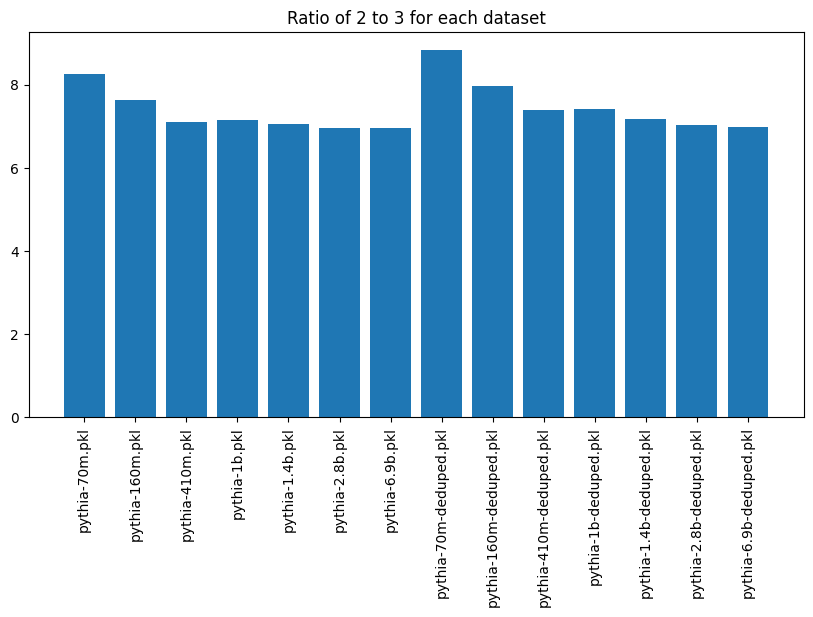

In [54]:
# plot ratio_2_3
plt.figure(figsize=(10, 5))
plt.bar(df_ratios['file'], df_ratios['ratio_2_3'])
# rotate xticks
plt.xticks(rotation=90)
plt.title('Ratio of 2 to 3 for each dataset')

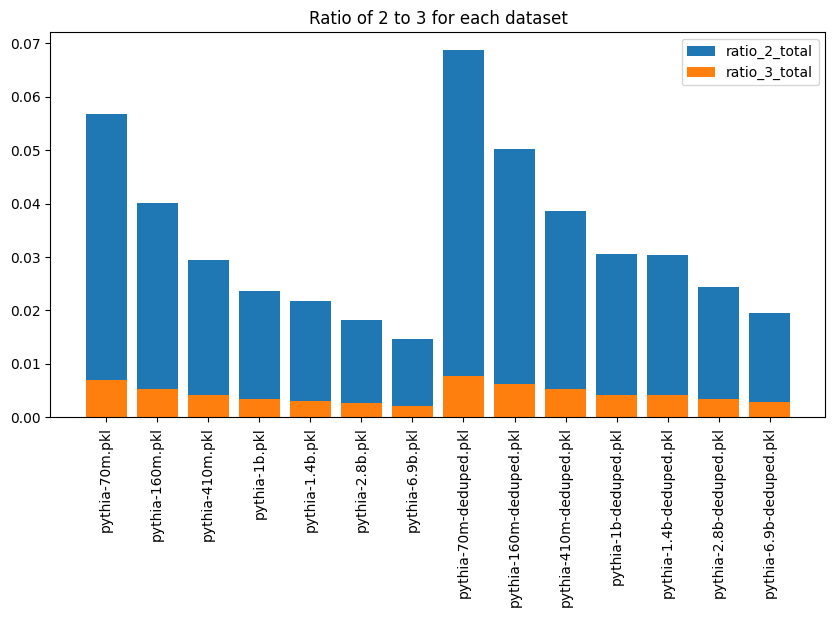

In [55]:
# plot ratio_2_total and ratio_3_total
plt.figure(figsize=(10, 5))
plt.bar(df_ratios['file'], df_ratios['ratio_2_total'], label='ratio_2_total')
plt.bar(df_ratios['file'], df_ratios['ratio_3_total'], label='ratio_3_total')
# rotate xticks
plt.xticks(rotation=90)
plt.title('Ratio of 2 to 3 for each dataset')
plt.legend()

Text(0.5, 1.0, 'Ratio of not memorized to total for each dataset')

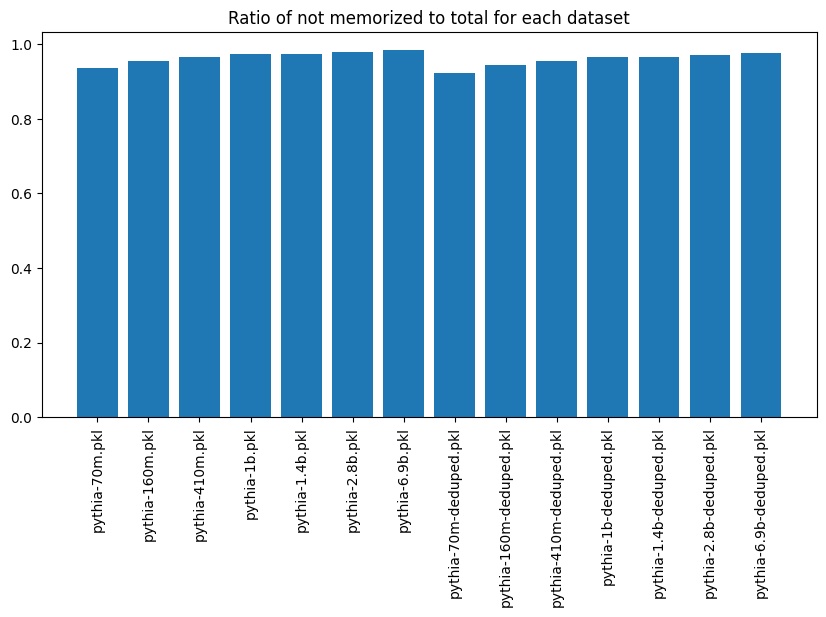

In [56]:
# plot ratio_not_memorized_total
plt.figure(figsize=(10, 5))
plt.bar(df_ratios['file'], df_ratios['ratio_not_memorized_total'])
# rotate xticks
plt.xticks(rotation=90)
plt.title('Ratio of not memorized to total for each dataset')

In [50]:
df_ratios.to_csv('../data/exact_match_ratios.csv')

In [38]:
# Stitch together the plots into a pdf
import glob
from fpdf import FPDF
from PIL import Image

pdf = FPDF()
# imagelist is the list with all image filenames
files = glob.glob('../plots/*.png')
# choose files with lrs in the name
files = [file for file in files if 'chunk_length' in file]
for image in files:
    pdf.add_page()
    pdf.image(image, 0, 0, 210, 220)
pdf.output("../plots/exact_match.pdf", "F")

''